In [1]:
import pymc as pm
import numpy as np
from datetime import datetime
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(101)

start = datetime(2023, 1, 1)
end = datetime(2023, 12, 31)

market = yf.Ticker('SPY').history(start=start,end=end)
stock = yf.Ticker('MSFT').history(start=start,end=end)
risk_free_rate = yf.Ticker('^TNX').history(start=start,end=end)

In [3]:
daily_returns = pd.DataFrame()
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100
daily_returns['riskfree'] = (1 + risk_free_rate['Close'])**(1/360)-1

daily_returns = daily_returns.ffill()
daily_returns = daily_returns.dropna()

y = daily_returns['stock'] - daily_returns['riskfree']
x = daily_returns['market'] - daily_returns['riskfree']

In [4]:
test_size = 10
x_train = x[:-test_size]
y_train = y[:-test_size]
x_test = x[-test_size:]
y_test = y[-test_size:]

In [19]:
model = pm.Model()
with model:
    alpha = pm.Normal('alpha',mu=0.02,sigma=0.10)
    beta = pm.Normal('beta',mu=1.2,sigma=0.15)
    epsilon = pm.HalfStudentT('epsilon',sigma=0.20,nu=6)
    x = pm.MutableData('x',x_train,dims='x_data')
    y = pm.MutableData('y',y_train,dims='y_data')
    y_expected = pm.Deterministic('y_expected',alpha + beta * x, dims='x_data')
    y_likelihood = pm.StudentT('y_likelihood', mu=y_expected,sigma=epsilon,nu=6,observed=y,dims='y_data')


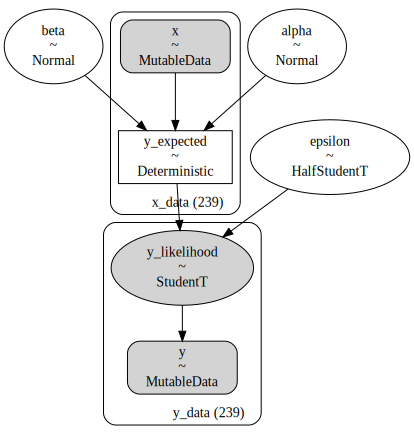

In [20]:
pm.model_to_graphviz(model)

In [21]:
graph = pm.model_to_graphviz(model)
graph.render(filename='model_graph', format='png', cleanup=True)

'model_graph.png'

In [22]:
idata = pm.sample_prior_predictive(samples=1000,model=model,return_inferencedata=True,random_seed=28)


Sampling: [alpha, beta, epsilon, y_likelihood]


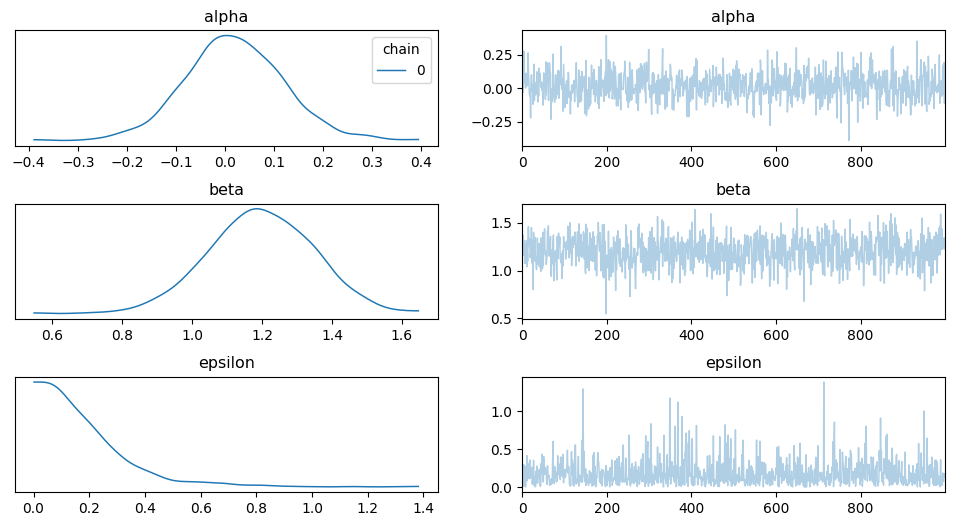

In [26]:
az.plot_trace(idata.prior,kind='trace',var_names=['alpha','beta','epsilon'],legend=True)
plt.subplots_adjust(hspace=0.5)
plt.savefig('prior_trace_plot.png')

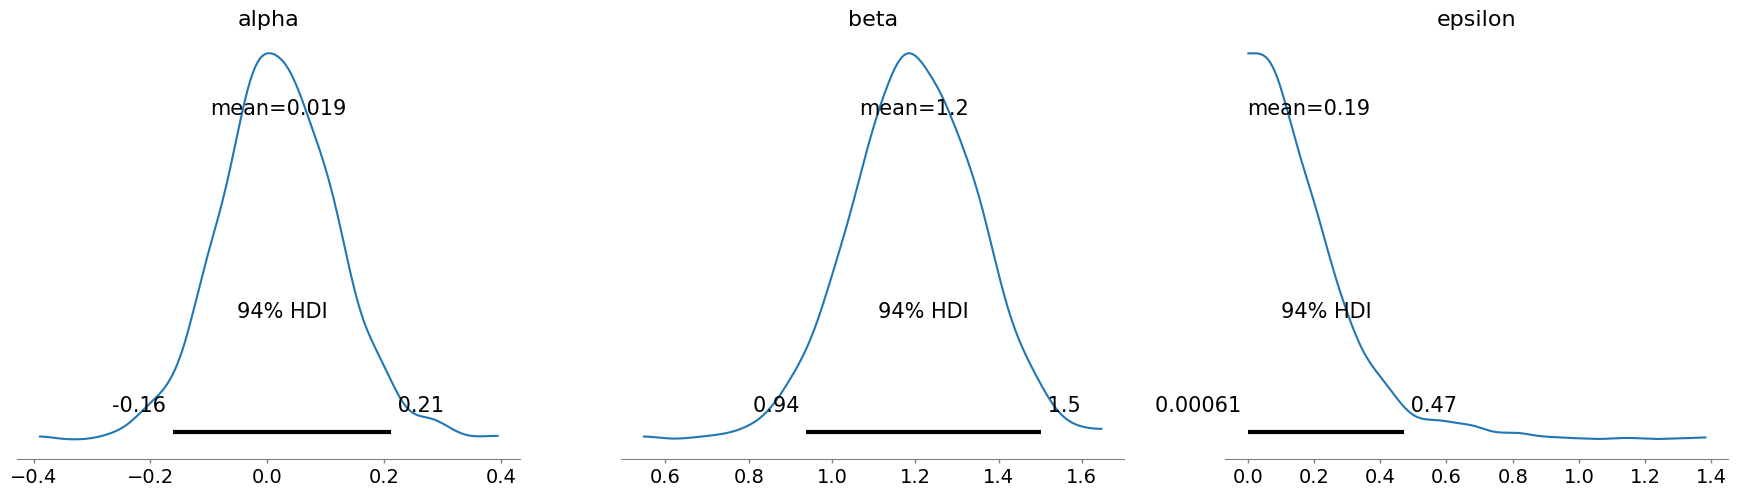

In [27]:
az.plot_posterior(idata.prior,var_names=['alpha','beta','epsilon'],round_to=2)
plt.savefig('prior_hdi_plot.png')

In [28]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data